In [18]:
import os

In [19]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'
WORK_SPACE_PATH = os.path.join('Tensorflow', 'image_search_workspace')

In [20]:
paths = {
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc'),
    'WORKSPACE_PATH': WORK_SPACE_PATH,
    'ANNOTATION_PATH': os.path.join(WORK_SPACE_PATH, 'annotations'),
    'IMAGE_PATH': os.path.join(WORK_SPACE_PATH, 'images'),
    'MODEL_PATH': os.path.join(WORK_SPACE_PATH, 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join(WORK_SPACE_PATH, 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join(WORK_SPACE_PATH, 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join(WORK_SPACE_PATH, 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH': os.path.join(WORK_SPACE_PATH, 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH': os.path.join(WORK_SPACE_PATH, 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
}

In [21]:
print(paths)

{'SCRIPTS_PATH': 'Tensorflow\\scripts', 'APIMODEL_PATH': 'Tensorflow\\models', 'PROTOC_PATH': 'Tensorflow\\protoc', 'WORKSPACE_PATH': 'Tensorflow\\image_search_workspace', 'ANNOTATION_PATH': 'Tensorflow\\image_search_workspace\\annotations', 'IMAGE_PATH': 'Tensorflow\\image_search_workspace\\images', 'MODEL_PATH': 'Tensorflow\\image_search_workspace\\models', 'PRETRAINED_MODEL_PATH': 'Tensorflow\\image_search_workspace\\pre-trained-models', 'CHECKPOINT_PATH': 'Tensorflow\\image_search_workspace\\models\\my_ssd_mobnet', 'OUTPUT_PATH': 'Tensorflow\\image_search_workspace\\models\\my_ssd_mobnet\\export', 'TFJS_PATH': 'Tensorflow\\image_search_workspace\\models\\my_ssd_mobnet\\tfjsexport', 'TFLITE_PATH': 'Tensorflow\\image_search_workspace\\models\\my_ssd_mobnet\\tfliteexport'}


In [14]:
files = {
    'PIPELINE_CONFIG': os.path.join(WORK_SPACE_PATH, 'models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [16]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# # Create Label Map

In [15]:
labels = [{'name': 'Ama', 'id': 1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

3. Create TF Records

In [18]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

Successfully created the TFRecord file: Tensorflow\image_search_workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\image_search_workspace\annotations\test.record


4. Copy Model Config to Training Folder

In [20]:
if os.name == 'posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


5. Update Config For Transfer Learning

In [22]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [17]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [30]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [31]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,
                                                                 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [32]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [26]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [27]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=4000".format(TRAINING_SCRIPT,
                                                                                             paths['CHECKPOINT_PATH'],
                                                                                             files['PIPELINE_CONFIG'])

In [28]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\image_search_workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\image_search_workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=4000


7. Evaluate the Model

In [33]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT,
                                                                                          paths['CHECKPOINT_PATH'],
                                                                                          files['PIPELINE_CONFIG'],
                                                                                          paths['CHECKPOINT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\image_search_workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\image_search_workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\image_search_workspace\models\my_ssd_mobnet


8. Load Train Model From Checkpoint

In [18]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [27]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()


# @tf.function
def detect_fne(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

9. Detect from an Image

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [21]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [23]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'E2Q5kf4WUAws9GD.jpg')
print(IMAGE_PATH)

Tensorflow\image_search_workspace\images\test\E2Q5kf4WUAws9GD.jpg


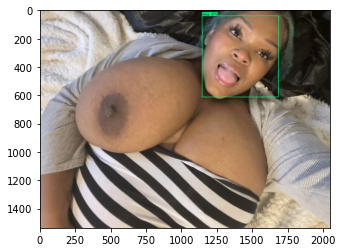

[0.97312635 0.23926711 0.10740396 0.07563382 0.04887277 0.04377076
 0.04291651 0.035954   0.03567183 0.03240246 0.03074044 0.02852985
 0.02658585 0.0245316  0.02390414 0.0225459  0.02011245 0.01995033
 0.01978287 0.01922399 0.01904064 0.01785216 0.01764959 0.01739424
 0.01650575 0.01628819 0.01605791 0.01555619 0.01538396 0.01529533
 0.01453394 0.01432875 0.01430219 0.0140346  0.01385719 0.01340699
 0.01339671 0.01327568 0.01293734 0.01269615 0.01265174 0.01200691
 0.01186472 0.01185596 0.01181877 0.01139417 0.01133236 0.01130602
 0.01119161 0.01117355 0.01112264 0.01107818 0.01093578 0.01066998
 0.01060185 0.01060128 0.01016876 0.01016575 0.0101535  0.01011536
 0.01008525 0.0099875  0.00995919 0.00994238 0.00977066 0.00976774
 0.00975007 0.00969884 0.00960189 0.00958133 0.0094071  0.00934929
 0.0091992  0.00917956 0.0091528  0.00910199 0.00892934 0.00889742
 0.00881296 0.00868639 0.00849527 0.00842759 0.00841975 0.00835487
 0.0083335  0.00829646 0.00827882 0.00824907 0.00822109 0.0082

In [24]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fne(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=.6,
    agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
print(detections['detection_scores'])

In [22]:
def get_detection_scores(img_path):
    img = cv2.imread(img_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fne(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    return detections['detection_scores']

In [31]:
def contains_specified_face(img_path):
    scores = get_detection_scores(img_path)
    print(scores)
    return scores[0] >= 0.6

In [4]:
def get_all_img_files(path):
    included_extensions = ['jpg', 'jpeg', 'bmp', 'png']
    file_names = [fn for fn in os.listdir(path)
              if any(fn.endswith(ext) for ext in included_extensions)]
    return file_names

search_dir = 'C:\\Users\\Emmanuel\\Downloads'
img_files = get_all_img_files(search_dir)

print(img_files)

['0 Vr22w3sQrFpGzksz.png', '0057.jpg', '0185362A-BA01-4063-9351-AD35153FD3B9.png', '02Sm-rg2EKL.jpg', '0462F035-F877-4663-A194-72606C4FCD16.jpeg', '064_Naked_exhibitionists_.jpg', '0gwzQ0Gn.jpg', '0_196.jpg', '0_899.jpg', '10.png', '101542453_296549911503968_4954547290884673125_n.jpg', '101940860_567913640786494_199183254403775945_n.jpg', '102689697_575824196399844_3977670055978045887_n.jpg', '103096409_127956152257543_8299050449896643542_n.jpg', '103357295_3881341615274532_5587349539834356412_n.jpg', '103385280_660303481485325_2285177052065883010_n.jpg', '107248570_285674469177436_3867787094430410303_n.jpg', '109546963_1148691575517693_4146485816985161582_n.jpg', '109774364_271744147447796_1337894238882461667_n.jpg', '11.png', '116876107_1028583284240871_138292215255620070_n.jpg', '117656323_353760315890702_4411082622096901601_n.jpg', '118118262_368311641001289_248280287149574302_n.jpg', '119159647_607768733224682_685223160893242504_n.jpg', '119436712_338982427447924_19222803264863415

In [36]:
print(contains_specified_face('C:\\Users\\Emmanuel\\Downloads\\0_899.jpg'))


[0.9796462  0.22530401 0.19731203 0.06531626 0.0522126  0.04778498
 0.04380322 0.0431225  0.04285437 0.03669518 0.03395689 0.02862775
 0.02588287 0.02361107 0.02215853 0.02016813 0.01983297 0.01953083
 0.01583457 0.01561514 0.01376322 0.01358595 0.01341596 0.0134047
 0.01274511 0.01240796 0.01210639 0.01191568 0.01167694 0.01165521
 0.0115799  0.01126575 0.01125851 0.0112471  0.01119518 0.01111171
 0.01093155 0.01088819 0.01074505 0.01062039 0.01019561 0.01006338
 0.0100421  0.00969759 0.00955003 0.00944152 0.00939196 0.00934416
 0.00929663 0.00921616 0.00921336 0.0090158  0.0089249  0.00881764
 0.008771   0.00877059 0.00864577 0.00854301 0.00849479 0.00838482
 0.00829956 0.00827882 0.00805917 0.00801605 0.00800073 0.00786409
 0.00778121 0.00757077 0.00749192 0.00748265 0.00747794 0.00739667
 0.0073345  0.00731423 0.00725904 0.00724098 0.00718686 0.00715339
 0.00714749 0.00708622 0.00705409 0.00705263 0.0070191  0.00701717
 0.00699577 0.00696579 0.0069508  0.00691915 0.00690758 0.00680